In [463]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow Version : " , tf.__version__)

Tensorflow Version :  2.19.0


Load and preprocess images

In [464]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

Change below data_dir PATH to your data set PATH and Download the flowers dataset

After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [465]:
from pathlib import Path

data_dir = Path('/Users/akshaykumar/Documents/GitHub/AI_ML/Project_for_team/Datasets/flower_photos/' )  # replace with your directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

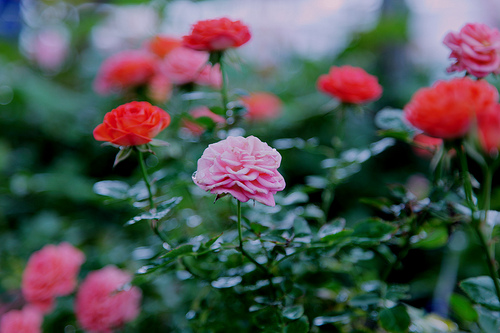

In [466]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [467]:
len(roses)

641

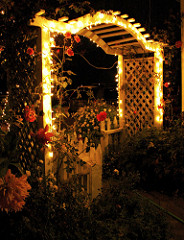

In [468]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[640]))

Load data using a Keras utility
Let's load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility.

In [469]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [470]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [471]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the class_names attribute on these datasets.

In [472]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [473]:
class_names = val_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


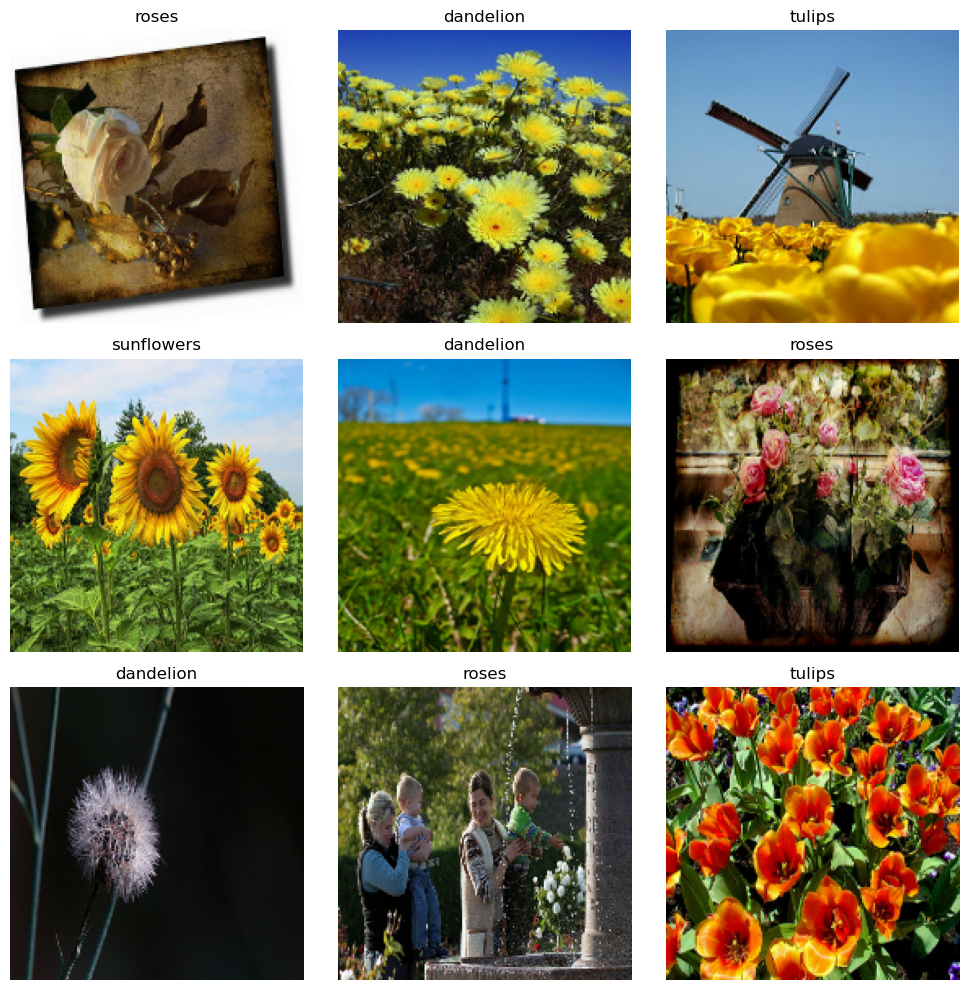

In [474]:
import matplotlib.pyplot as plt

def show_sample_images(dataset, class_names, num_images=9, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Usage example:
show_sample_images(train_ds, class_names)

Visualize the data
Here are the first nine images from the training dataset.

You can train a model using these datasets by passing them to model.fit (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [475]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on either of these tensors to convert them to a numpy.ndarray.

Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [476]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [477]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.


In [478]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Train a model
For completeness, you will show how to train a simple model using the datasets you have just prepared.

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created.

In [479]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [480]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [481]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.3009 - loss: 1.5444 - val_accuracy: 0.5545 - val_loss: 1.1074
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.5677 - loss: 1.0584 - val_accuracy: 0.5817 - val_loss: 1.0690
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.6569 - loss: 0.8914 - val_accuracy: 0.5981 - val_loss: 1.0197
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.7192 - loss: 0.7615 - val_accuracy: 0.6322 - val_loss: 1.0062
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.7822 - loss: 0.5997 - val_accuracy: 0.6444 - val_loss: 1.0865
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.8322 - loss: 0.4600 - val_accuracy: 0.6403 - val_loss: 1.2735
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.8733 - loss: 0.3604 - val_accuracy: 0.6185 - val_loss: 1.3229
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9052 - loss: 0.2988 - val_accu

Using tf.data for finer control
The above Keras preprocessing utility—tf.keras.utils.image_dataset_from_directory—is a convenient way to create a tf.data.Dataset from a directory of images.

For finer grain control, you can write your own input pipeline using tf.data. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

In [482]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [483]:
for f in list_ds.take(5):
  print(f.numpy())

b'/Users/akshaykumar/Documents/GitHub/AI_ML/Project_for_team/Datasets/flower_photos/daisy/3326037909_b5ae370722_n.jpg'
b'/Users/akshaykumar/Documents/GitHub/AI_ML/Project_for_team/Datasets/flower_photos/daisy/5881907044_92a85a05c8_n.jpg'
b'/Users/akshaykumar/Documents/GitHub/AI_ML/Project_for_team/Datasets/flower_photos/daisy/2488902131_3417698611_n.jpg'
b'/Users/akshaykumar/Documents/GitHub/AI_ML/Project_for_team/Datasets/flower_photos/dandelion/9293460423_7fbb1e3c32_n.jpg'
b'/Users/akshaykumar/Documents/GitHub/AI_ML/Project_for_team/Datasets/flower_photos/daisy/4820415253_15bc3b6833_n.jpg'


The tree structure of the files can be used to compile a class_names list.

In [484]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name not in ("LICENSE.txt", ".DS_Store")]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into training and validation sets:

In [485]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

You can print the length of each dataset as follows:

In [486]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an (img, label) pair:

In [487]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [488]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [489]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use Dataset.map to create a dataset of image, label pairs:

In [490]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [491]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


Configure dataset for performance
To train a model with this dataset you will want the data:

To be well shuffled.
To be batched.
Batches to be available as soon as possible.

In [492]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [493]:
print(val_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Visualize the data
You can visualize this dataset similarly to the one you created previously:

2025-05-24 10:04:02.666203: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


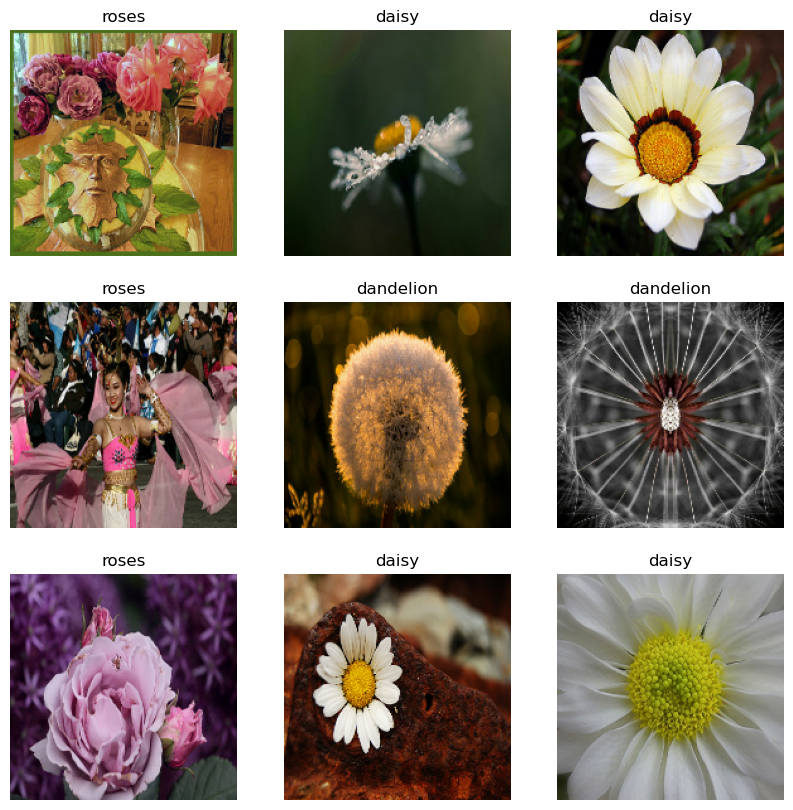

In [494]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

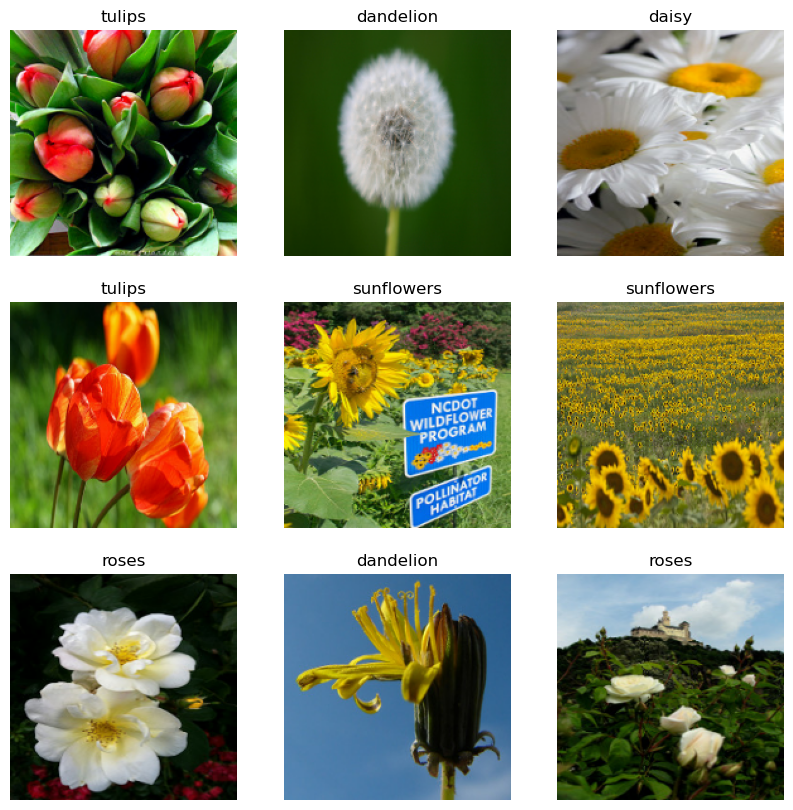

In [495]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")